## Business Problem

Our team of data scientists work together on a team for a new growing movie platform looking to compete with other giants such as Netflix, Hulu, and HBO. Our aim is to create a unique experience for each of our customers while subtly increasing our ROI. We aim to achieve this by building a tailored, unique recommendation system that can effectively suggest movies to our users, in order to continue to engage them with our platform. We want to be able to make predictions to our existing clients, as well as use our recommendation system as a product we use to attract new users to our platform. Additionally, as we continue to build up our recommendation systems, we plan to build our platform by investing in newer content for users to enjoy.

### Initial cleaning

In [1]:
#Import relevant packages
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

We will begin our EDA by importing the files from the MovieLens database that are necessary for our analysis: movies.csv and ratings.csv.

In [2]:
#Import the movies csv file 
movies = pd.read_csv('movies.csv')
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [3]:
#Import the ratings csv file 
ratings = pd.read_csv('ratings.csv')
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


In [4]:
#Will probably disregard this dataframe, doesn't seem as impactful.
tags = pd.read_csv('tags.csv')
tags.head(2)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996


In [5]:
#Unique values in each dataframe
movies.nunique()

movieId    9742
title      9737
genres      951
dtype: int64

In [6]:
# Show unique values in ratings dataframe
ratings.nunique()

userId         610
movieId       9724
rating          10
timestamp    85043
dtype: int64

For this project, we will require both users, movies and ratings in one DataFrame so we will therefore merge our files together.

In [7]:
#Merge movies and ratings dataframes for easier reference.
df = pd.merge(ratings, movies, on='movieId', how='left')

In [8]:
#Look at first two rows of merged dataframe
df.head(2)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance


In [9]:
#Drop 'timestamp' as this column is unnecessary
data = df.drop(['timestamp'], axis=1)

In [10]:
#Add a feature 'year' that shows which year the movie is from 
data['year'] = data['title'].str.extract('.*\((.*)\).*',expand = False)
data.head(5)

,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,1995
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,1995
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995


Before we continue, let us check on the sparsity of our matrix. 

In [11]:
#Check sparsity of matrix
numratings = len(data['rating'])
numusers = len(data['userId'].unique())
numitems = len(data['movieId'].unique())

sparse = 1 - (numratings / (numusers*numitems))
sparse

0.9830003169443864

Our matrix is very sparse; 98%. We will now filter the data frame to deal with sparsity and create a denser utility matrix, by removing users who have provided a low number of ratings (less than 200) and movies that were rated less frequently (less than 10 times).

In [12]:
#Filter out users who have rated less than 200 movies 
data = data.groupby('userId').filter(lambda x: len(x)>200)

In [13]:
#Filter out movies who have rated less than 10 movies 
data = data.groupby('movieId').filter(lambda x: len(x)>10)

Let's now recheck the sparsity of our matrix.

In [14]:
#Check sparsity of new matrix
numratings = len(data['rating'])
numusers = len(data['userId'].unique())
numitems = len(data['movieId'].unique())

sparse = 1 - (numratings / (numusers*numitems))
sparse

0.7931695867508024

This result looks pretty good; our resulting matrix is much less sparse, at 79%, so we hope this will allow for improvements in our future SVD models. Let's continue with cleaning and investigate our results.

We will look for NA values in our dataset and consequently drop any rows that contain NA values, as the relevant information in these rows are incomplete and no longer useful to our analysis.

In [15]:
#Check for NA values 
data.isna().sum()

userId     0
movieId    0
rating     0
title      0
genres     0
year       0
dtype: int64

In [16]:
#Drop any NA values 
data.dropna(inplace=True)

In [17]:
#Confirm no NA values are left
data.isna().sum()

userId     0
movieId    0
rating     0
title      0
genres     0
year       0
dtype: int64

It will be important for us to understand which movies have the highest number of views, the highest ratings, etc. Before we begin any graphical representations of this, we will first look at the distribution of the different columns in our DataFrame.

In [18]:
#See which movie Ids have the highest number of views
data['movieId'].value_counts()

356     119
2571    113
260     111
1196    107
296     105
       ... 
6550     11
1515     11
4351     11
533      11
3564     11
Name: movieId, Length: 1717, dtype: int64

In [19]:
#See which users have provided the most ratings
data['userId'].value_counts()

414    1370
599    1171
68      997
474     901
448     894
       ... 
4       156
234     156
605     138
594     136
563      95
Name: userId, Length: 133, dtype: int64

In [20]:
#View the distribution of ratings 
data['rating'].value_counts()

4.0    12991
3.0     9065
3.5     6970
5.0     5598
4.5     4265
2.0     3239
2.5     2911
1.0     1030
1.5      716
0.5      447
Name: rating, dtype: int64

In [21]:
#View the distribution of years 
data['year'].value_counts()

2000    2405
1999    2357
1995    2198
2001    2142
1997    2039
        ... 
1938      13
1931      12
1934      12
1947      12
1922      11
Name: year, Length: 85, dtype: int64

In [22]:
#Investigate the number of unique years 
data['year'].nunique()

85

Firstly, let's take a look at which years were the most popular for movies in our dataset.

/Users/adinasteinman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


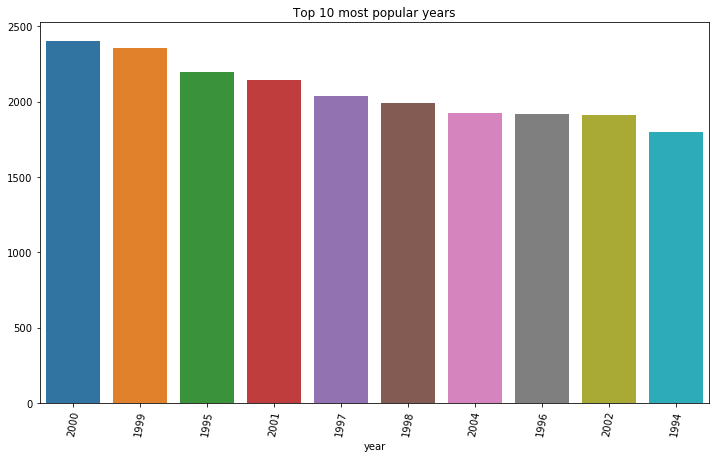

In [23]:
#Top 10 Years with the most movies produced.
plt.figure(figsize=(12,7))
topyear = data.groupby('year').size().sort_values(ascending=False).head(10)
sns.barplot(topyear.index, topyear.values)
plt.title('Top 10 most popular years')
plt.xticks(rotation=80);

Recommendation systems often have a 'popularity bias'; where films that are more popular (watched more, rated higher by viewers, etc.) are recommended more often than other films. As a result, we will identify which movies in our dataset have the highest ratings, as well as which movies have been the most watched by viewers, in order to look out for popularity bias later on when we conduct our modeling.

In [24]:
#Print the average ratings of movies 
data.groupby('title').mean()['rating'].sort_values(ascending=False)

title
Double Indemnity (1944)                       4.590909
Paths of Glory (1957)                         4.545455
Ran (1985)                                    4.500000
Streetcar Named Desire, A (1951)              4.458333
Shawshank Redemption, The (1994)              4.457895
                                                ...   
Superman IV: The Quest for Peace (1987)       1.687500
Flintstones in Viva Rock Vegas, The (2000)    1.681818
Problem Child (1990)                          1.636364
Battlefield Earth (2000)                      1.571429
Speed 2: Cruise Control (1997)                1.535714
Name: rating, Length: 1717, dtype: float64

We see that the top 3 rated movies are Double Idemnity, Paths of Glory and Ran; all who have approx  4.5 star ratings. There will be may other films that also have very popular, high ratings of 4.5 stars, and it is important that we look out for these films whne we recommend movies later on, as these films may be presented as recommendations due to popularity bias.

/Users/adinasteinman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


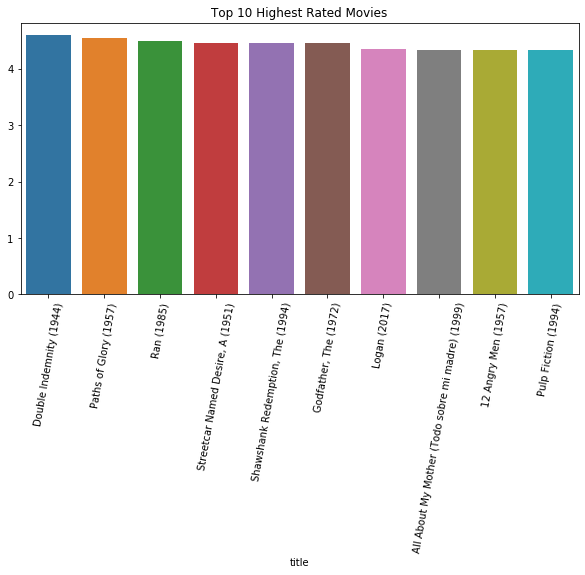

In [25]:
#Plot the top 10 highest rated movies
plt.figure(figsize=(10,5))
topmovies = data.groupby('title').mean()['rating'].sort_values(ascending=False).head(10)
sns.barplot(topmovies.index, topmovies.values)
plt.title('Top 10 Highest Rated Movies')
plt.xticks(rotation=80);

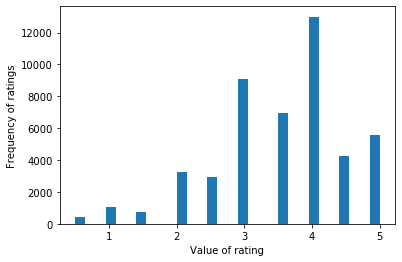

In [26]:
#Plot a histogram of the frequency of certain rating values
plt.hist(data['rating'],bins=30)
plt.xlabel('Value of rating')
plt.ylabel('Frequency of ratings')
plt.show()

In [27]:
# Look at how many times each movie has been watched
data.groupby('title').size().sort_values(ascending=False)

title
Forrest Gump (1994)                                                   119
Matrix, The (1999)                                                    113
Star Wars: Episode IV - A New Hope (1977)                             111
Star Wars: Episode V - The Empire Strikes Back (1980)                 107
Pulp Fiction (1994)                                                   105
                                                                     ... 
Around the World in 80 Days (1956)                                     11
Englishman Who Went Up a Hill But Came Down a Mountain, The (1995)     11
Enter the Dragon (1973)                                                11
Purple Rose of Cairo, The (1985)                                       11
Fantastic Beasts and Where to Find Them (2016)                         11
Length: 1717, dtype: int64

/Users/adinasteinman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


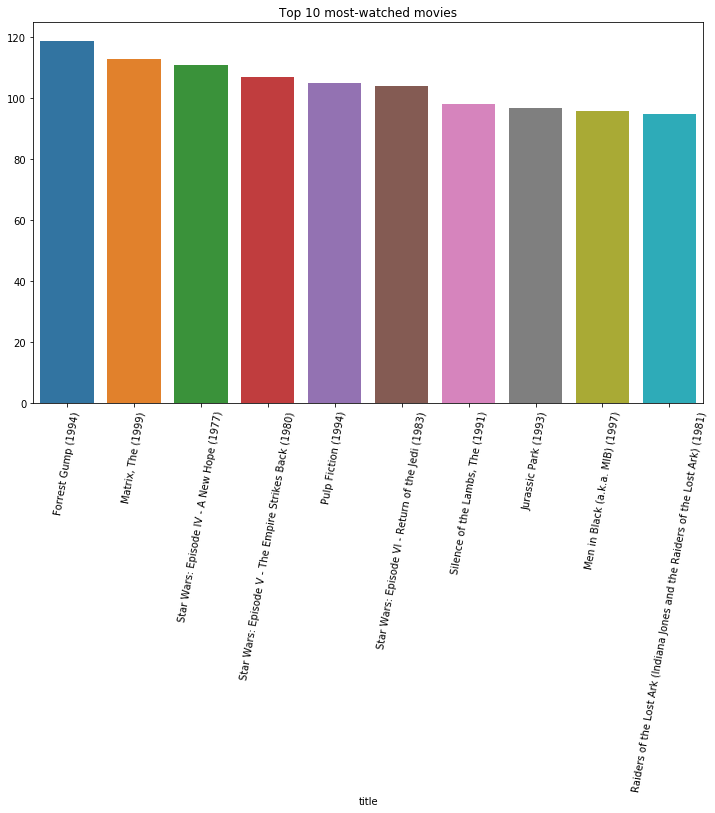

In [28]:
#Plot the top 10 most watched movies
plt.figure(figsize=(12,7))
topmovies = data.groupby('title').size().sort_values(ascending=False).head(10)
sns.barplot(topmovies.index, topmovies.values)
plt.title('Top 10 most-watched movies')
plt.xticks(rotation=80);

In [29]:
#Creat genre labels
genrelabels = set()
for i in data['genres'].str.split('|').values:
    genrelabels = genrelabels.union(set(i))

In [30]:
#Print genres
genrelabels

{'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [31]:
#Create function that counts how many movies there are of each genre 
def genrecounts(df, col, labels):
    count = dict()
    for i in labels: count[i] = 0
    for value in df[col].str.split('|'):
        if type(value) == float and pd.isnull(value): continue
        for i in value: 
            if pd.notnull(i): count[i] += 1
    return count                                       

In [32]:
#Apply the genrecounts formula to our dataset and print the resulting genres and their counts 
genre_count = genrecounts(data, 'genres', genrelabels)
genre_count

{'Sci-Fi': 9700,
 'War': 2132,
 'Adventure': 13281,
 'Musical': 2141,
 'IMAX': 2283,
 'Animation': 3567,
 'Action': 16493,
 'Drama': 18015,
 'Children': 4715,
 'Horror': 3182,
 'Comedy': 18932,
 'Film-Noir': 467,
 'Crime': 8232,
 'Romance': 8259,
 'Western': 929,
 'Thriller': 13128,
 'Mystery': 3846,
 'Fantasy': 6509,
 'Documentary': 192}

In [33]:
#Create a dataframe for the genres and their value counts 
genres = pd.DataFrame(list(genre_count.items()),columns = ['Genre','Frequency'])

In [34]:
#Sort the DataFrame
genres = genres.sort_values(by=['Frequency'], ascending=False)

In [35]:
#Print the resulting DataFrame 
genres

,Genre,Frequency
10,Comedy,18932
7,Drama,18015
6,Action,16493
2,Adventure,13281
15,Thriller,13128
0,Sci-Fi,9700
13,Romance,8259
12,Crime,8232
17,Fantasy,6509
8,Children,4715


/Users/adinasteinman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


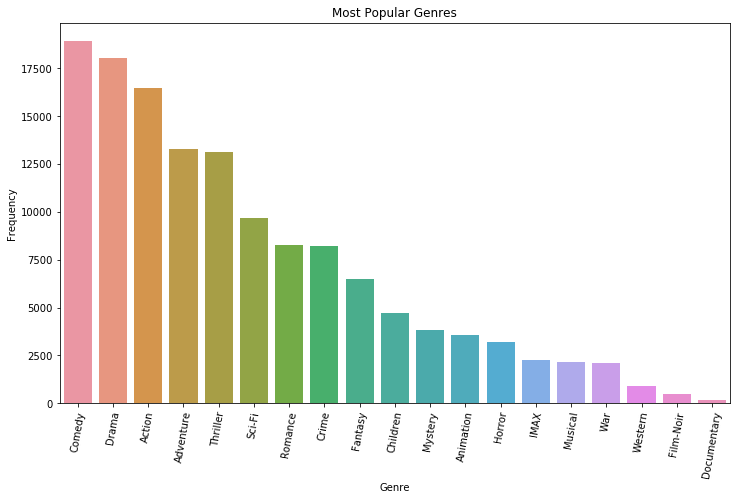

In [36]:
#Plot the top most watched movie genres
plt.figure(figsize=(12,7))
sns.barplot(genres['Genre'], genres['Frequency'])
plt.title('Most Popular Genres')
plt.xticks(rotation=80);

We see that Comedy, Drama, and Action are the top 3 genres that are watched by viewers. Again, this information could involve popularity bias when conducting our models; our models may be prone to recommending films that are in Drama, Comedy and Action genres; therefore we must look out for this bias when recommending films to users with our models.

#### Additional EDA

In [37]:
#look at the original dataframe again
data.head()

,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,1995
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,1995
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995


In [38]:
#Create columns for each genre to indicate T/F
for genre in genrelabels:
    data[genre] = data['genres'].apply(lambda x: genre in x)

In [39]:
#Boolean values for each genre across every movie in the data frame.
pd.set_option('max_columns', None)
data.head(2)

,userId,movieId,rating,title,genres,year,Sci-Fi,War,Adventure,Musical,IMAX,Animation,Action,Drama,Children,Horror,Comedy,Film-Noir,Crime,Romance,Western,Thriller,Mystery,Fantasy,Documentary
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,False,False,True,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,1995,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False


In [40]:
#Create a logical matrix now that the genres have been parsed.
matrix = data.drop(['userId', 'movieId', 'rating', 'genres', 'year'], axis=1)
matrix.head(2)

,title,Sci-Fi,War,Adventure,Musical,IMAX,Animation,Action,Drama,Children,Horror,Comedy,Film-Noir,Crime,Romance,Western,Thriller,Mystery,Fantasy,Documentary
0,Toy Story (1995),False,False,True,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False
1,Grumpier Old Men (1995),False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False


/Users/adinasteinman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/adinasteinman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/adinasteinman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an

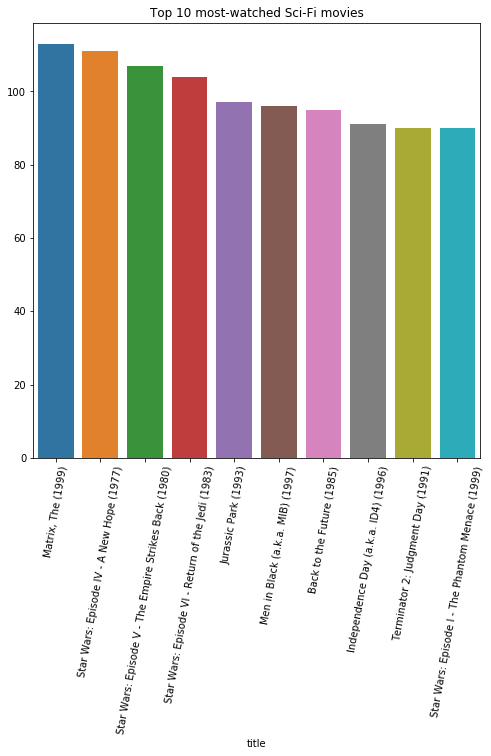

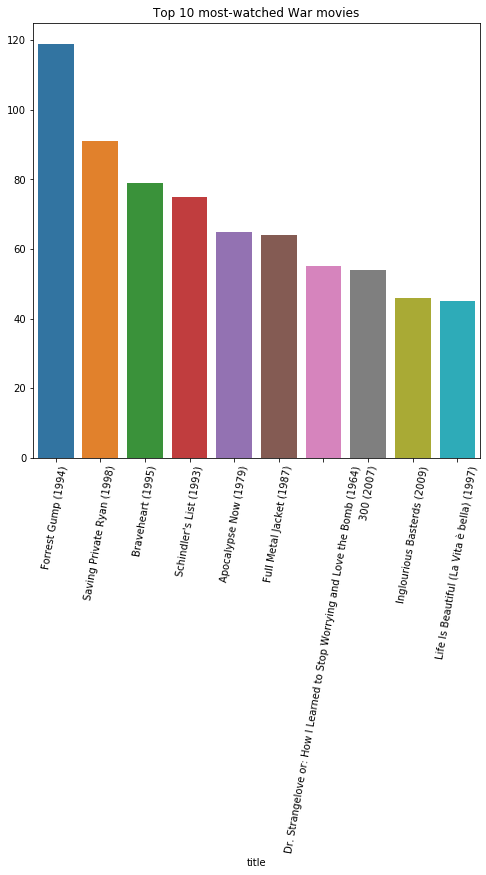

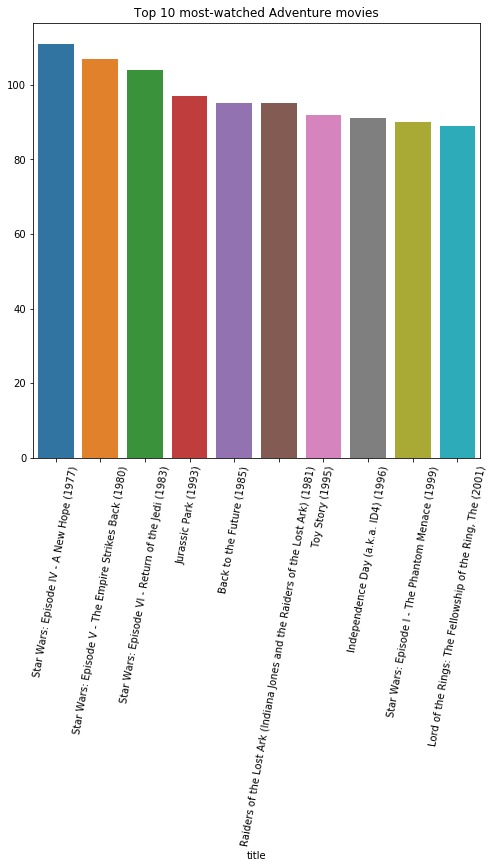

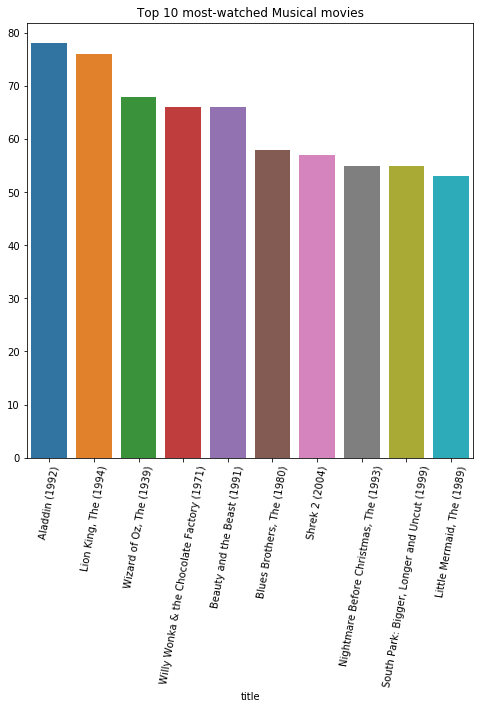

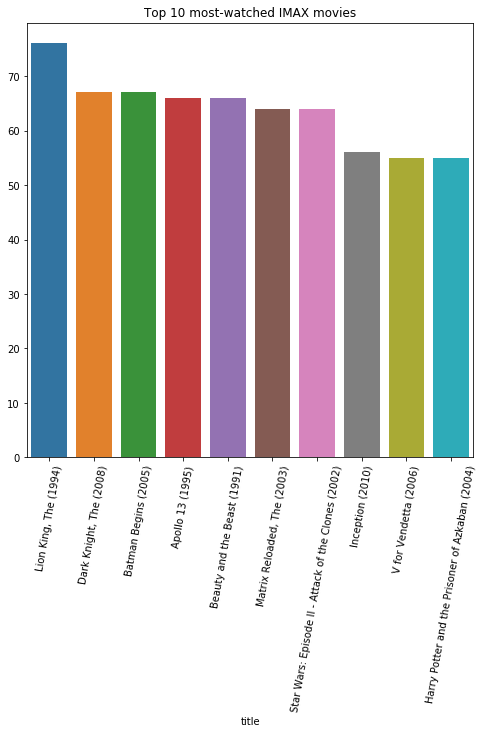

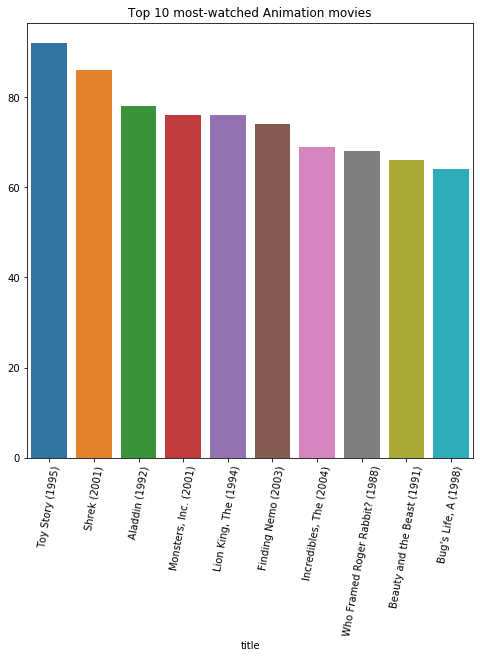

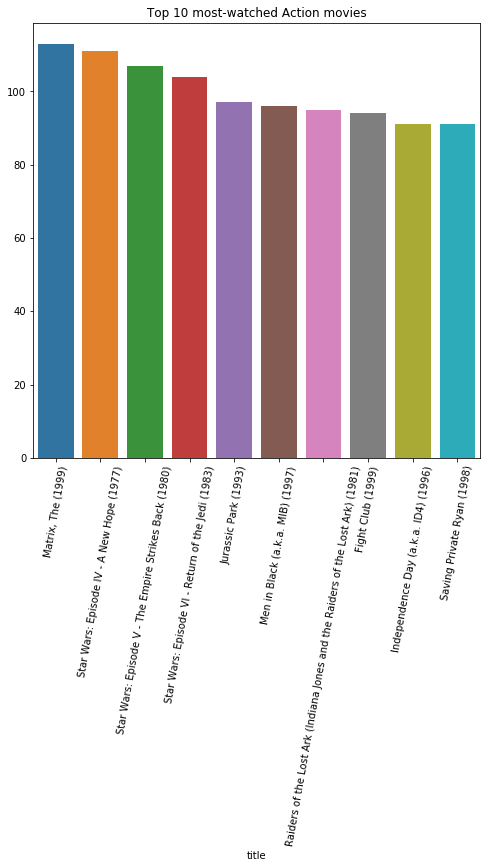

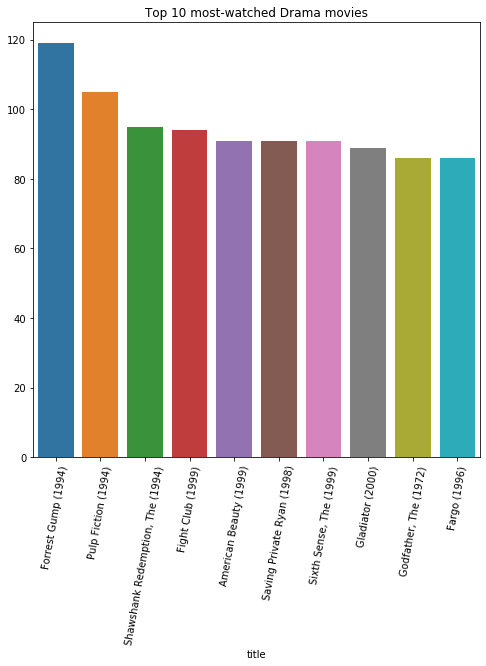

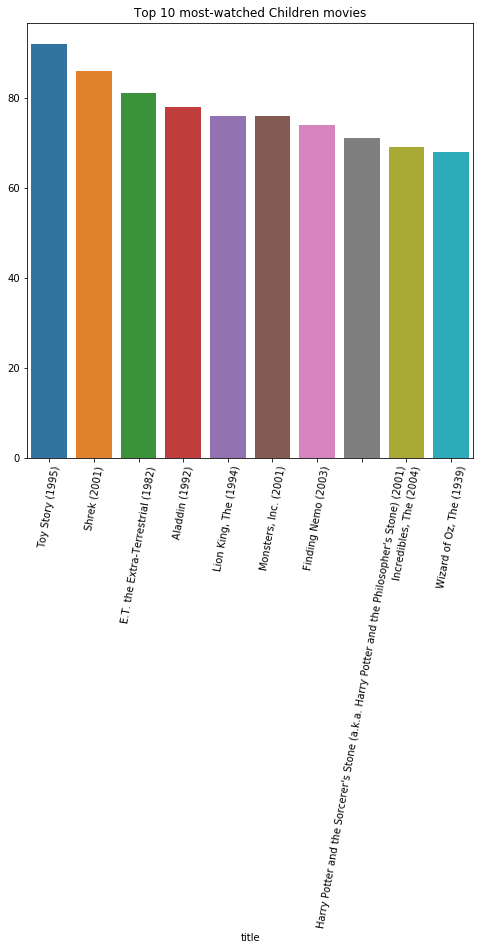

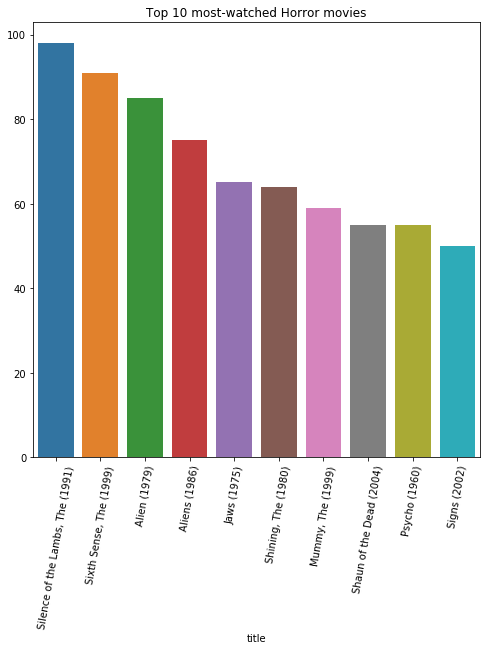

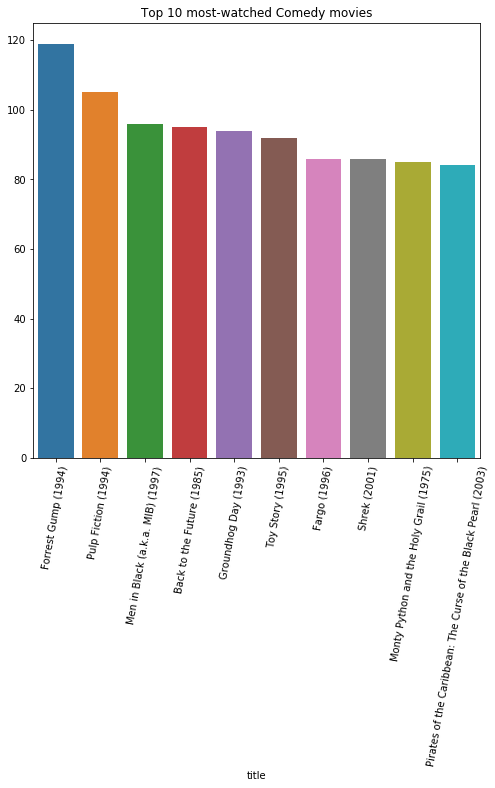

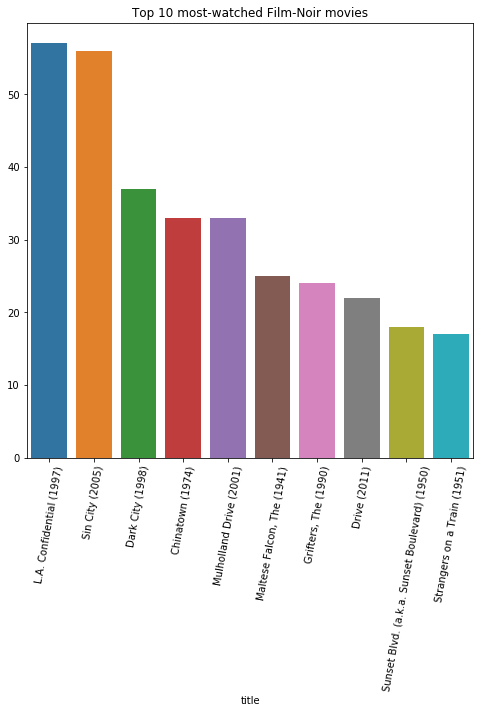

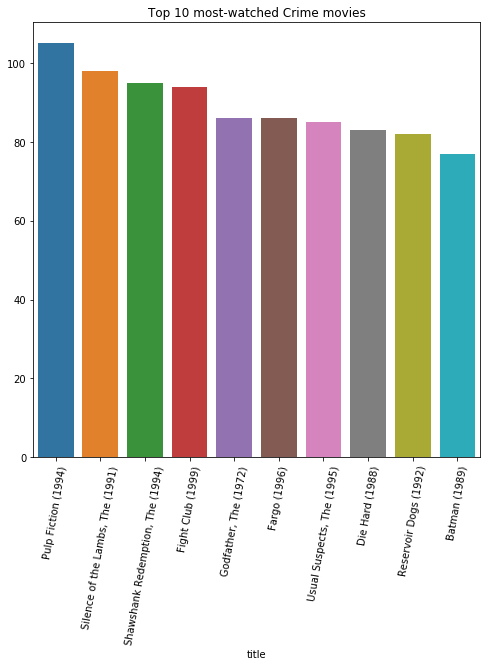

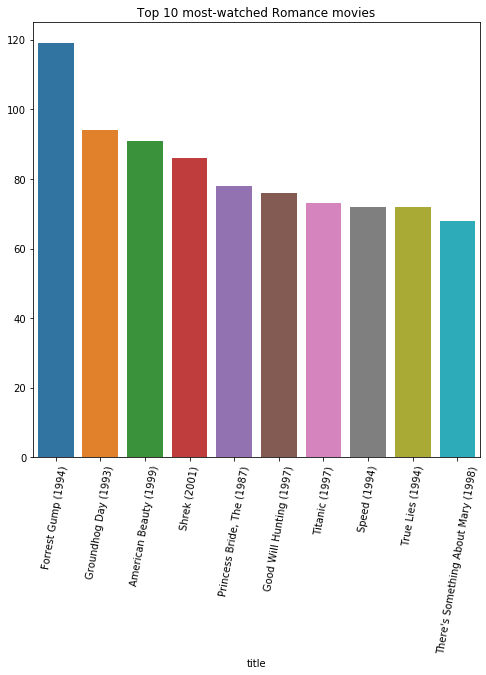

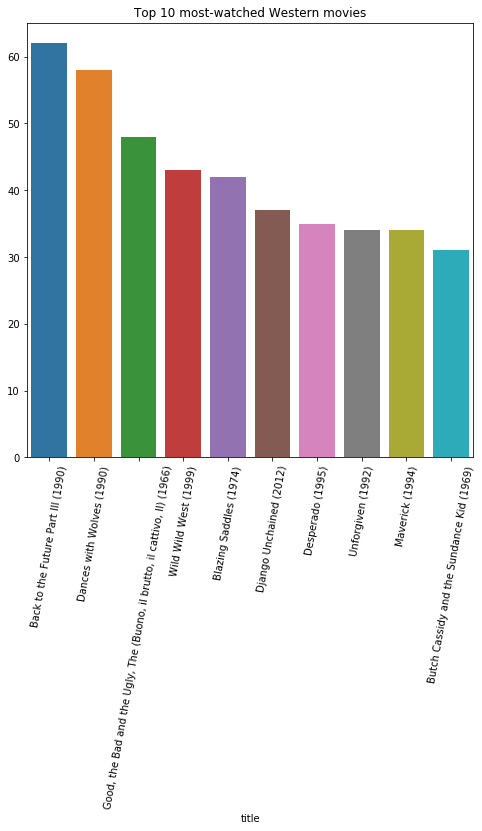

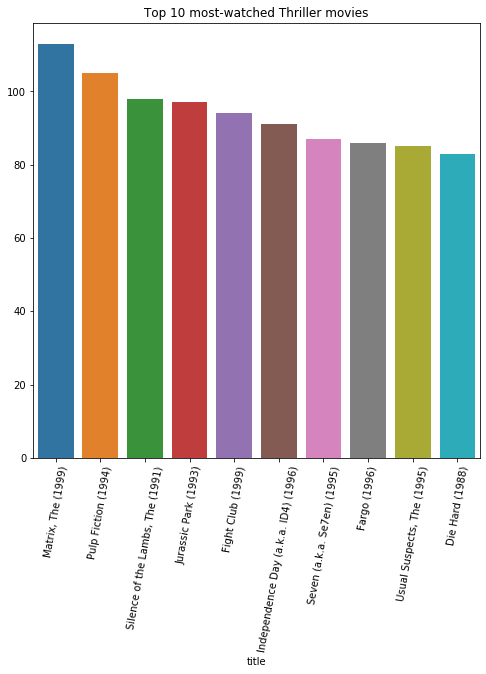

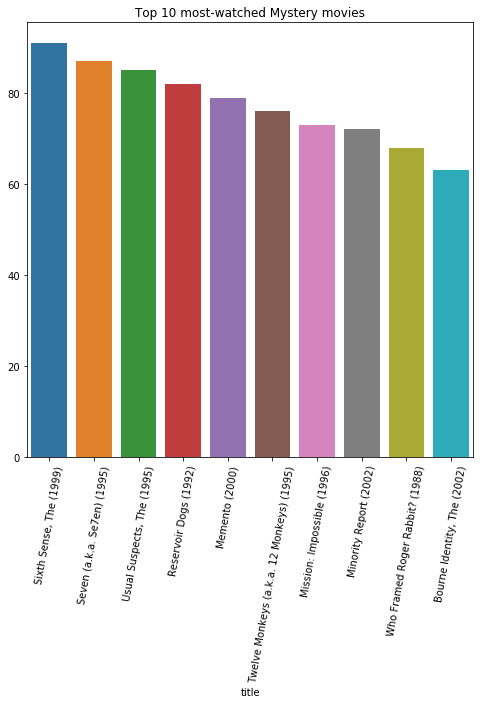

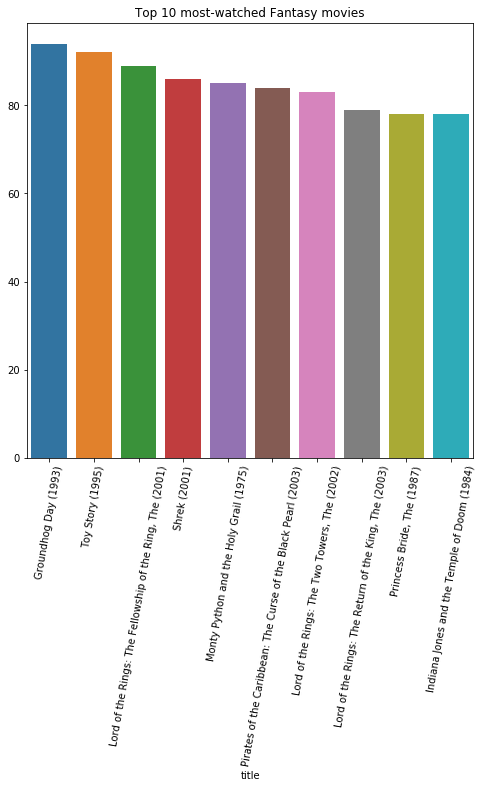

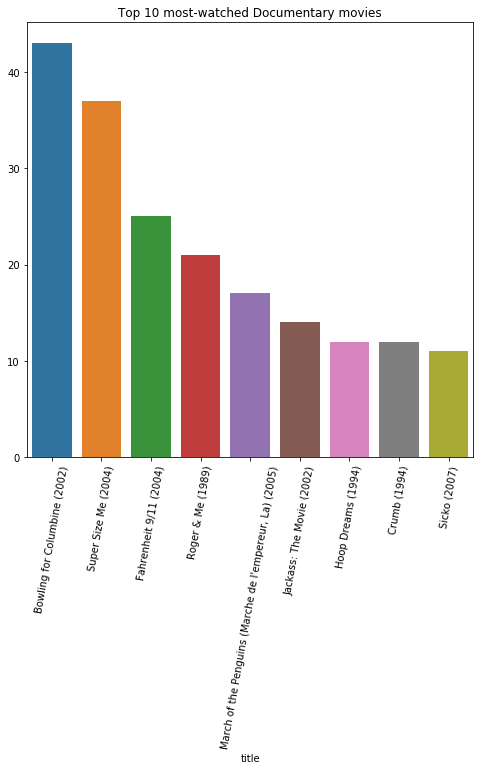

In [41]:
#Create a loop that will plot the top 10 most watched movies.  
for gen in matrix.columns[1:]:
    x = matrix[(matrix[gen]==True)]
    plt.figure(figsize=(8,8))
    topmovies = x.groupby('title').size().sort_values(ascending=False).head(10)
    sns.barplot(topmovies.index, topmovies.values)
    plt.title('Top 10 most-watched '+gen+' movies')
    plt.xticks(rotation=80);

In [42]:
#Looking at which movies are most popular in the fantasy genre
fantasy = data[(data['Fantasy']==True)]
fantasy.head(5)

,userId,movieId,rating,title,genres,year,Sci-Fi,War,Adventure,Musical,IMAX,Animation,Action,Drama,Children,Horror,Comedy,Film-Noir,Crime,Romance,Western,Thriller,Mystery,Fantasy,Documentary
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,False,False,True,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False
22,1,367,4.0,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,1994,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False
35,1,596,5.0,Pinocchio (1940),Animation|Children|Fantasy|Musical,1940,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False
38,1,661,5.0,James and the Giant Peach (1996),Adventure|Animation|Children|Fantasy|Musical,1996,False,False,True,True,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False
39,1,673,3.0,Space Jam (1996),Adventure|Animation|Children|Comedy|Fantasy|Sc...,1996,True,False,True,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False


/Users/adinasteinman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


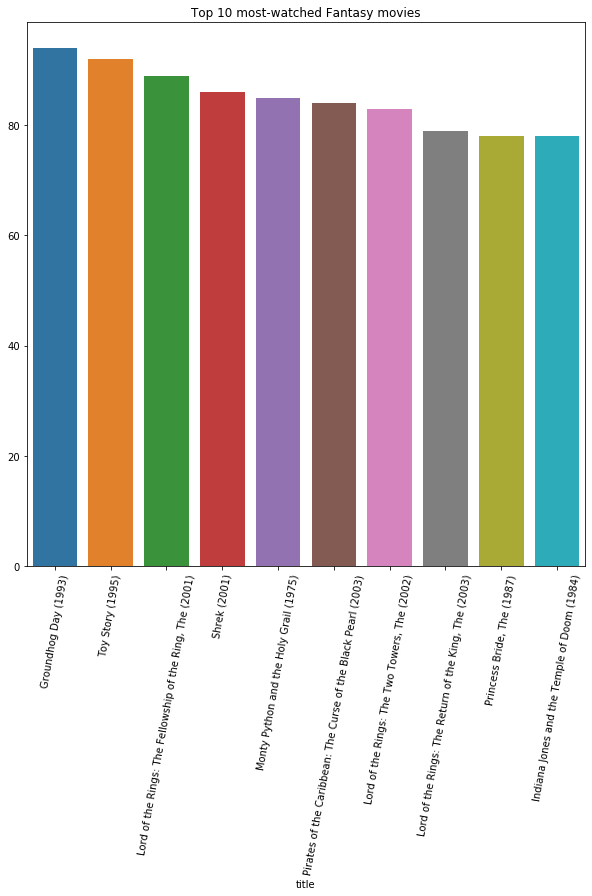

In [43]:
#Plot the top 10 most-watched fantasy movies 
plt.figure(figsize=(10,10))
topmovies = fantasy.groupby('title').size().sort_values(ascending=False).head(10)
sns.barplot(topmovies.index, topmovies.values)
plt.title('Top 10 most-watched Fantasy movies')
plt.xticks(rotation=80);

/Users/adinasteinman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


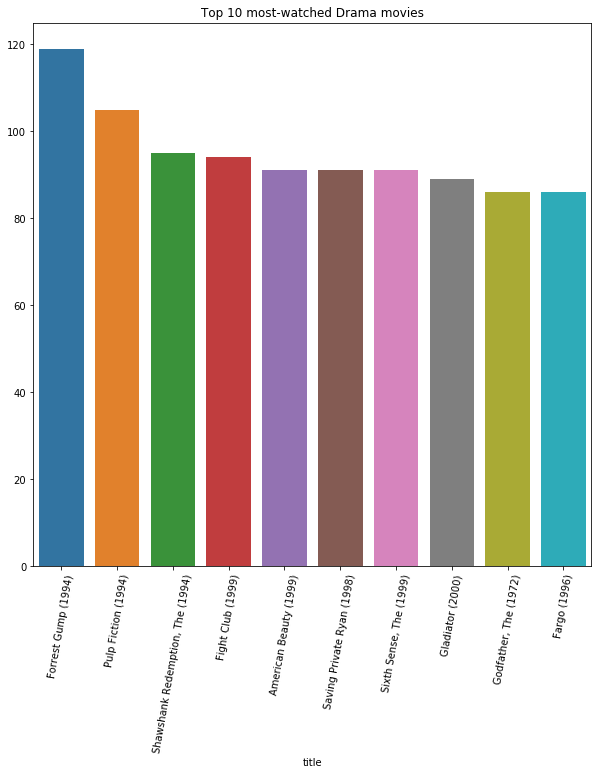

In [44]:
#Looking at which movies are most popular in the Drama genre
drama = data[(data['Drama']==True)]
plt.figure(figsize=(10,10))
topmovies = drama.groupby('title').size().sort_values(ascending=False).head(10)
sns.barplot(topmovies.index, topmovies.values)
plt.title('Top 10 most-watched Drama movies')
plt.xticks(rotation=80);

/Users/adinasteinman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


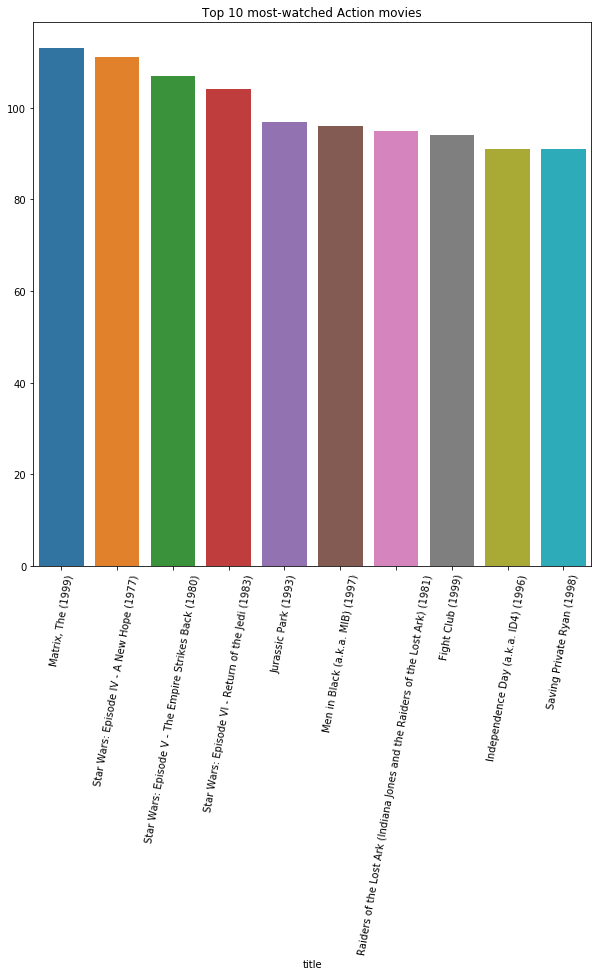

In [45]:
#Looking at which movies are most popular in the Action genre
action = data[(data['Action']==True)]
plt.figure(figsize=(10,10))
topmovies = action.groupby('title').size().sort_values(ascending=False).head(10)
sns.barplot(topmovies.index, topmovies.values)
plt.title('Top 10 most-watched Action movies')
plt.xticks(rotation=80);

/Users/adinasteinman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


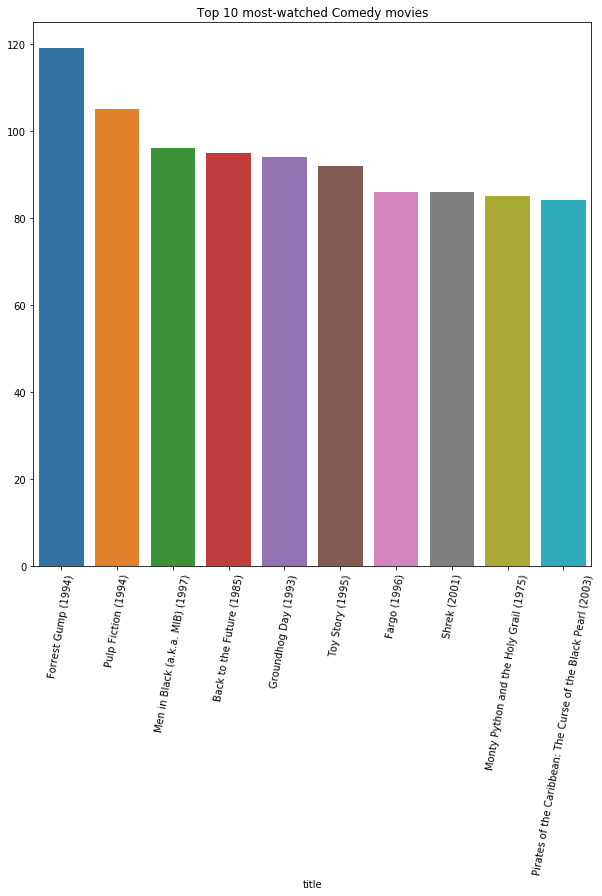

In [46]:
#Looking at which movies are most popular in the Comedy genre
comedy = data[(data['Comedy']==True)]
plt.figure(figsize=(10,10))
topmovies = comedy.groupby('title').size().sort_values(ascending=False).head(10)
sns.barplot(topmovies.index, topmovies.values)
plt.title('Top 10 most-watched Comedy movies')
plt.xticks(rotation=80);

/Users/adinasteinman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


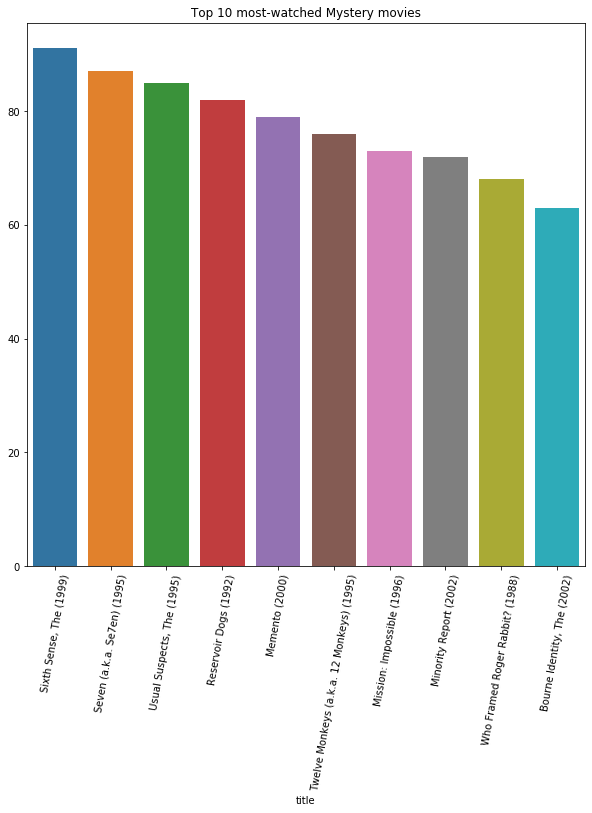

In [47]:
#Looking at which movies are most popular in the Mystery genre
mystery = data[(data['Mystery']==True)]
plt.figure(figsize=(10,10))
topmovies = mystery.groupby('title').size().sort_values(ascending=False).head(10)
sns.barplot(topmovies.index, topmovies.values)
plt.title('Top 10 most-watched Mystery movies')
plt.xticks(rotation=80);

In [48]:
#Export the resulting data to a csv file 
data.to_csv('cleaneddata')